In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import lifeline
import community
import fieldsetter
import advectParticles

In [15]:
reload(plot)
reload(lifeline)
reload(community)
reload(fieldsetter)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/home/students/4302001/arctic-connectivity/tools/advectParticles.py'>

In [16]:
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/rcp8.5/ocean/arctic/'
readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_rcp8.5run_years_2000-2010_arctic.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = '/scratch/DaanR/psets/'

In [17]:
xr.open_dataset(readdir_ocean+fieldfile_ocean)

<xarray.Dataset>
Dimensions:  (record: 4007, time: 1, x: 3600, y: 600)
Coordinates:
  * time     (time) float64 2e+07
Dimensions without coordinates: record, x, y
Data variables:
    UVEL_5m  (record, time, y, x) float32 ...
    VVEL_5m  (record, time, y, x) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.0 (http://...
    Conventions:                POP MOVIE conventions
    history:                    Mon Sep 16 16:30:22 2019: ncecat daan_1.nc da...
    title:                      POP MOVIE file
    nsteps_total:               240
    iyear:                      2000
    imonth:                     1
    iday:                       10
    tday:                       1.0
    NCO:                        "4.6.0"
    history_of_appended_files:  Mon Sep 16 15:52:22 2019: Appended file VVEL_...
    CDO:                        Climate Data Operators version 1.7.0 (http://...
    nco_openmp_thread_number:   1

In [18]:
timestamps = [[np.datetime64('2000-01-09', 'D') + np.timedelta64(day, 'D') for day in range(4007)]]
fieldset = fieldsetter.read_velocity_field(readdir_ocean+fieldfile_ocean, 
                                           meshfile = readdir_mesh+meshfile,
                                           tindex = 'record',
                                           timestamps = timestamps)


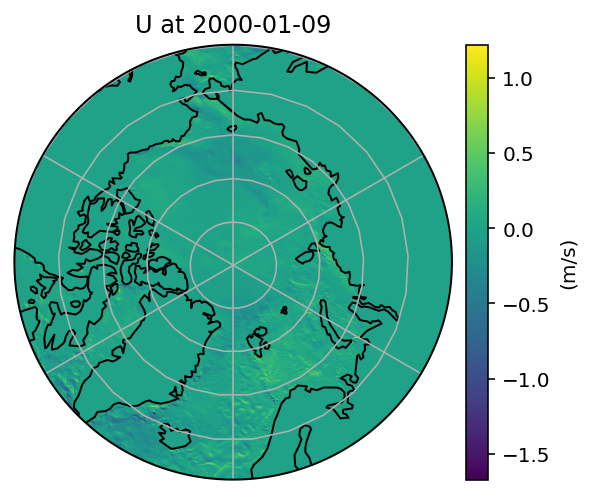

In [19]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))

In [20]:
#add_ice_fields(fieldset, readdir_ice+fieldfile_ice, meshfile=readdir_mesh+meshfile)

In [21]:
bins_1deg = community.regularCountBins(112, 27, minLat=59, maxLat=86, minLon=-46, maxLon=66)
bins_05deg = community.regularCountBins(222, 52, minLat=59, maxLat=86, minLon=-45.6, maxLon=65.5)

In [71]:
bins_1deg_m2 = community.regularCountBins(112, 27, minLat=59, maxLat=86, minLon=-46, maxLon=66)



In [35]:
particles = community.particles.from_regular_grid(2200, 500, 
                                                  minLat=60, 
                                                  maxLat=85, 
                                                  minLon=-45, 
                                                  maxLon=65, 
                                                   releaseTime = datetime(2000,1,9))
particles.remove_on_land(fieldset)

<Figure size 432x288 with 0 Axes>

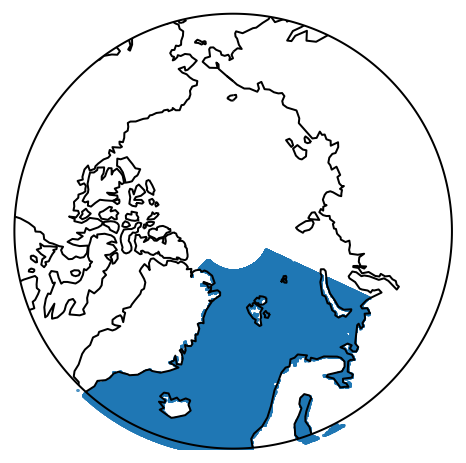

In [36]:
fig = plt.figure()
ax = particles.show(projection = ccrs.NorthPolarStereo(central_longitude=0.0, globe=None), s=0.1)
circle_clip = plot.set_circular_boundary(ax)
ax.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())
plt.show()

In [37]:
initCount = bins_1deg.particle_count(particles).T

(<Figure size 864x288 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7fc4accb1128>)

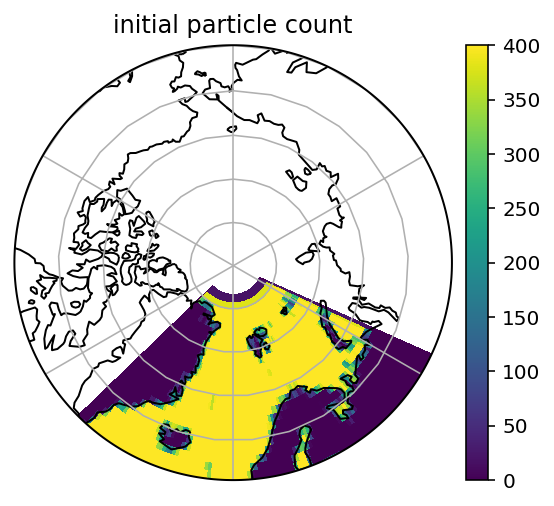

In [38]:
plot.field_from_dataset(bins_1deg.lonBounds, bins_1deg.latBounds, initCount, latRange=(60,90), title='initial particle count', polar=True, size=(12,4))

In [39]:
print("Sum of initCount on particleGrid:", bins_1deg.initCount.sum())
print("Removed particle count:", particles.removedParticleCount)
print("Particle count:", particles.n)

Sum of initCount on particleGrid: 706876.0
Removed particle count: 393124
Particle count: 706876


In [13]:
# #ADVECTION TAKES PLACE HERE
# psetTest = advectParticles.gridAdvection(fieldset, particleG, experiment_name='test_lr')

In [14]:
#particleG.add_advected('/data/oceanparcels/output_data/data_Daan/pset_control_y300_P3590x590_S2000-7-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')

In [15]:
# advected_ds = xr.open_dataset('/data/oceanparcels/output_data/data_Daan/pset_control_y300_P3590x590_S2000-1-1_D90_DT60_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')

In [16]:
# plot.from_dataset(countG.lonBounds, countG.latBounds, countG.particleCount(particleG, tindex=1).T, latRange=(60,90), title='final particle count', polar=True, size=(12,4), vmax=240)

In [46]:
particlesIcoInit, particlesIcoFinal = community.lonlat_from_pset("/data/oceanparcels/output_data/data_Daan/psets/pset_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65.nc", timedelta64=np.timedelta64(30, 'D'))

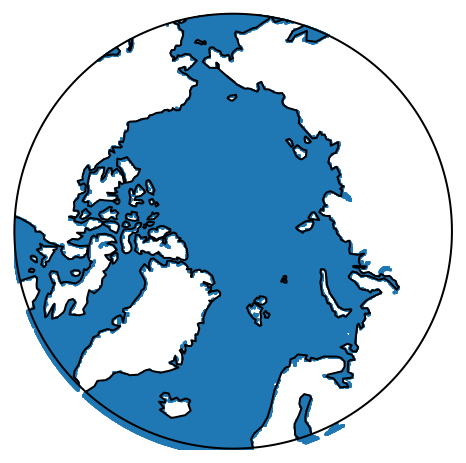

In [18]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude = 0.0, globe = None))
ax.scatter(particlesIcoInit[0,:,0], particlesIcoInit[0,:,1], s = 0.1, transform = ccrs.Geodetic())
ax.set_extent((-180, 180, 60, 90), crs = ccrs.PlateCarree())
ax.coastlines()
circle_clip = plot.set_circular_boundary(ax)
plt.show()

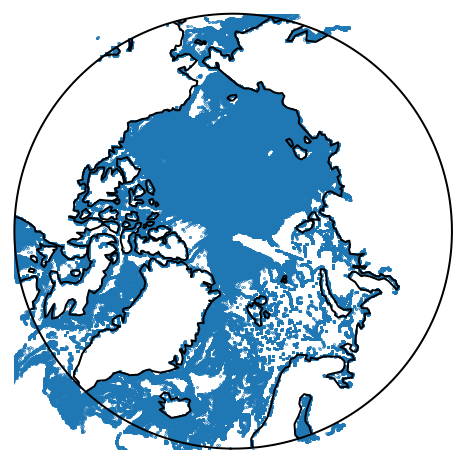

In [19]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude = 0.0, globe = None))
ax.scatter(particlesIcoFinal[0,:,0], particlesIcoFinal[0,:,1], s = 0.1, transform = ccrs.Geodetic())
ax.set_extent((-180, 180, 60, 90), crs = ccrs.PlateCarree())
ax.coastlines()
circle_clip = plot.set_circular_boundary(ax)
plt.show()

In [48]:
transMat_1deg = community.transMat.from_pset('/data/oceanparcels/output_data/data_Daan/psets/pset_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65.nc', 
                                             bins_1deg, 
                                             np.timedelta64(30, 'D'))

 Determining particle bins. 100%

In [49]:
transMat_05deg = community.transMat.from_pset('/data/oceanparcels/output_data/data_Daan/psets/pset_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65.nc', 
                                              bins_05deg, 
                                              np.timedelta64(30, 'D'))

 Determining particle bins. 100%

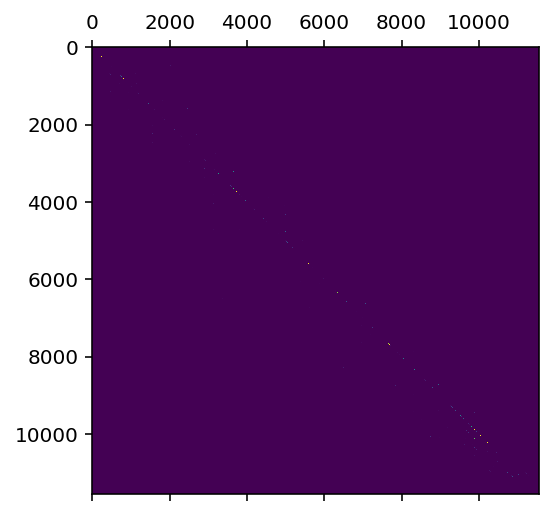

In [50]:
plt.matshow(transMat_05deg.data)
plt.show()

In [51]:
# Create network from numpy array (adjacency matrix)
G_1deg = nx.from_numpy_matrix(transMat_1deg.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_1deg, '/data/oceanparcels/output_data/data_Daan/networks/network_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C1deg.net')

In [65]:
# Create network from numpy array (adjacency matrix)
G_05deg = nx.from_numpy_matrix(transMat_05deg.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_05deg, '/data/oceanparcels/output_data/data_Daan/networks/network_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C05deg.net')

In [68]:
bins_1deg.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C1deg.clu')
bins_1deg.find_adjacency(mode='Moore');
bins_1deg.color_communities();
bins_05deg.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C05deg.clu')
bins_05deg.find_adjacency(mode='Moore');
bins_05deg.color_communities();

Graph is not planar!
Using 28 colors instead.
Graph is not planar!
Using 47 colors instead.


In [73]:
bins_1deg_m2.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C1deg_m2.clu')
bins_1deg_m2.find_adjacency(mode='Moore');
bins_1deg_m2.color_communities();

Graph is not planar!
Using 40 colors instead.


In [50]:
ice_ds = xr.open_dataset(readdir_ice+fieldfile_ice)
mesh_ds = xr.open_dataset(readdir_mesh+meshfile)

In [51]:
aice = ice_ds['aice']
tlon_mesh = mesh_ds['TLON']
tlat_mesh = mesh_ds['TLAT']

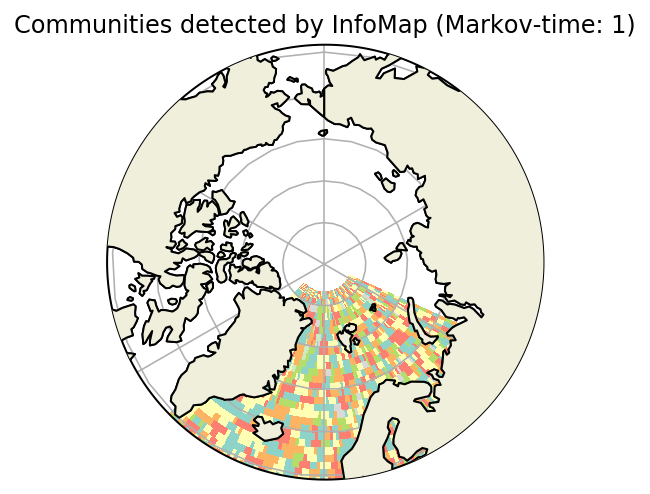

In [70]:
fig, ax = plot.field_from_dataset(bins_1deg.lonBounds, 
                                  bins_1deg.latBounds, 
                                  bins_1deg.colorID.reshape(bins_1deg.gridShape), 
                  colormap = 'Set3', 
                  title = 'Communities detected by InfoMap (Markov-time: 1)',
                  polar = True, 
                  land = True, 
                  latRange = (59,90),
                  export = 'Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C1deg.png',
                  cbar = False)
def icemask():
    circle_clip = plot.set_circular_boundary(ax)
    clip_path=(circle_clip, ax.transAxes)
    return ax.pcolormesh(tlon_mesh,
                          tlat_mesh,
                          np.ma.masked_array(aice[0,:,:], aice[0,:,:] < 0.1), 
                          transform = ccrs.PlateCarree(),
                          clip_path = (circle_clip, ax.transAxes),
                          cmap = cmocean.cm.ice,
                          vmin = 0., vmax = 1)

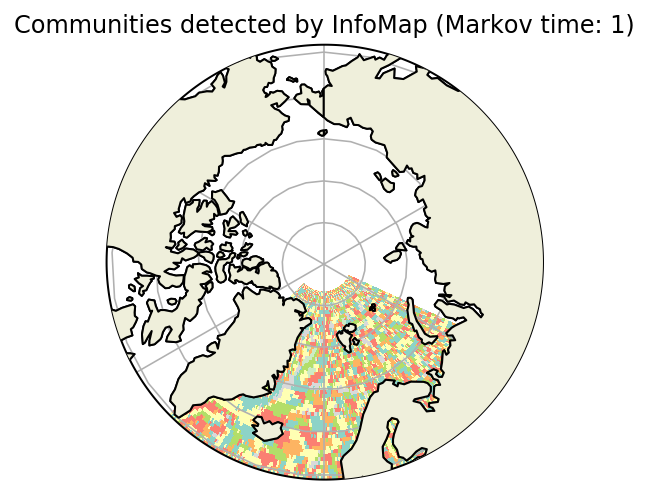

In [69]:
fig, ax = plot.field_from_dataset(bins_05deg.lonBounds, 
                                  bins_05deg.latBounds, 
                                  bins_05deg.colorID.reshape(bins_05deg.gridShape), 
                  colormap = 'Set3', 
                  title = 'Communities detected by InfoMap (Markov time: 1)',
                  polar = True, 
                  land = True, 
                  latRange = (59,90),
                  export = 'Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C05deg.png',
                  cbar = False)

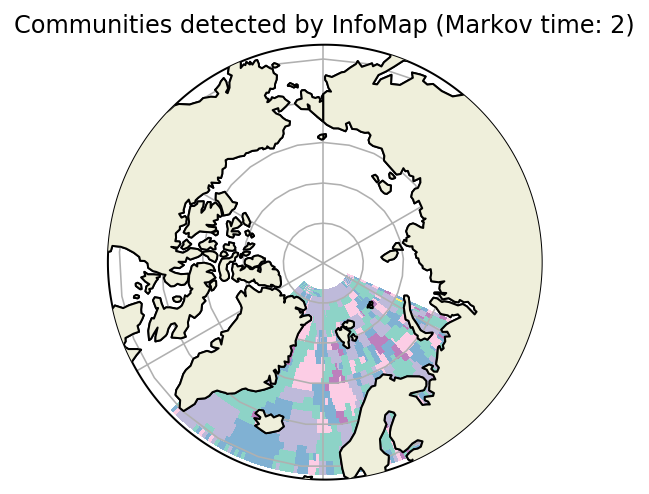

In [75]:
fig, ax = plot.field_from_dataset(bins_1deg_m2.lonBounds, 
                                  bins_1deg_m2.latBounds, 
                                  bins_1deg_m2.colorID.reshape(bins_1deg_m2.gridShape), 
                  colormap = 'Set3', 
                  title = 'Communities detected by InfoMap (Markov time: 2)',
                  polar = True, 
                  land = True, 
                  latRange = (58,90),
                  export = 'Rrcp85_P2200x500_S2000-01-09_D30_DT20_ODT12_LAT60-85_LON-45-65_C05deg_m2.png',
                  cbar = False)